In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imadeddineabid","key":"828da3efb51e680470e13638d9285fa7"}'}

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store -p /content/data
!unzip /content/data/ecommerce-behavior-data-from-multi-category-store.zip -d /content/data


Dataset URL: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
License(s): copyright-authors
100% 4.27G/4.29G [01:05<00:00, 61.8MB/s]
100% 4.29G/4.29G [01:05<00:00, 70.8MB/s]
Archive:  /content/data/ecommerce-behavior-data-from-multi-category-store.zip
  inflating: /content/data/2019-Nov.csv  
  inflating: /content/data/2019-Oct.csv  


In [4]:
DATA_DIR = "/content/data"


In [5]:
import os, pandas as pd

DATA_DIR = "/content/data"
csv_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".csv")]
print("الملفات الموجودة:", csv_files)

sample = pd.read_csv(csv_files[0], nrows=5)
print("أعمدة البيانات:")
print(sample.columns.tolist())
sample.head()


الملفات الموجودة: ['/content/data/2019-Oct.csv', '/content/data/2019-Nov.csv']
أعمدة البيانات:
['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session']


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


🔹 الخطوة 2: تحميل البيانات الضخمة على دفعات (chunks) لتجنّب نفاد الذاكرة

In [6]:
import pandas as pd
import gc
from collections import Counter
import time

file_path = "/content/data/2019-Oct.csv"

chunksize = 500_000
event_counter = Counter()
start = time.time()

for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
    event_counter.update(chunk["event_type"].values)
    del chunk
    gc.collect()

end = time.time()
print("أكثر الأحداث تكراراً:")
print(event_counter.most_common())
print(f"الوقت المستغرق: {end - start:.2f} ثانية")


أكثر الأحداث تكراراً:
[('view', 40779399), ('cart', 926516), ('purchase', 742849)]
الوقت المستغرق: 114.76 ثانية


In [7]:
total_rows = 0
file_path = "/content/data/2019-Oct.csv"
chunksize = 500_000

reader = pd.read_csv(file_path, chunksize=chunksize, low_memory=False)

for i, chunk in enumerate(reader):
    print(f"✅ تمت قراءة الجزء رقم {i+1}, شكله {chunk.shape}")
    total_rows += len(chunk)
    print(f"📦 مجموع الصفوف المقروءة: {total_rows}")

✅ تمت قراءة الجزء رقم 1, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 500000
✅ تمت قراءة الجزء رقم 2, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 1000000
✅ تمت قراءة الجزء رقم 3, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 1500000
✅ تمت قراءة الجزء رقم 4, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 2000000
✅ تمت قراءة الجزء رقم 5, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 2500000
✅ تمت قراءة الجزء رقم 6, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 3000000
✅ تمت قراءة الجزء رقم 7, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 3500000
✅ تمت قراءة الجزء رقم 8, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 4000000
✅ تمت قراءة الجزء رقم 9, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 4500000
✅ تمت قراءة الجزء رقم 10, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 5000000
✅ تمت قراءة الجزء رقم 11, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 5500000
✅ تمت قراءة الجزء رقم 12, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 6000000
✅ تمت قراءة الجزء رقم 13, شكله (500000, 9)
📦 مجموع الصفوف المقروءة: 6500000
✅ تمت قراءة الجزء رقم 

# الخطوة 3: تحليل بسيط — أكثر العلامات التجارية (brands) تكراراً لكل نوع حدث

In [8]:
import pandas as pd
import gc
from collections import Counter

file_path = "/content/data/2019-Oct.csv"
chunksize = 500_000

result = {}

for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
    for event_type, df_group in chunk.groupby("event_type"):
        top_brands = (
            df_group["brand"].value_counts().head(3).to_dict()
        )
        if event_type not in result:
            result[event_type] = Counter()
        result[event_type].update(top_brands)
    del chunk
    gc.collect()

for event_type, brands in result.items():
    print(f"\nالحدث: {event_type}")
    print("أشهر العلامات التجارية:", dict(brands.most_common(5)))


الحدث: cart
أشهر العلامات التجارية: {'samsung': 303249, 'apple': 209084, 'xiaomi': 104497}

الحدث: purchase
أشهر العلامات التجارية: {'samsung': 172896, 'apple': 142873, 'xiaomi': 56616}

الحدث: view
أشهر العلامات التجارية: {'samsung': 4806630, 'apple': 3770597, 'xiaomi': 2922650}


# الخطوة 4: تحويل البيانات إلى Parquet (اختياري  لتسريع التحليل )

In [9]:
import dask.dataframe as dd
import time

start = time.time()
ddf = dd.read_csv("/content/data/*.csv", assume_missing=True, blocksize="64MB")
ddf.to_parquet("/content/data/parquet_data", engine="pyarrow", compression="snappy")
end = time.time()

print(f"تم التحويل إلى Parquet خلال {end - start:.1f} ثانية.")


تم التحويل إلى Parquet خلال 336.9 ثانية.


#  الخطوة 5: تحليل باستخدام Dask (على جميع الملفات دفعة واحدة)

In [10]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

ddf = dd.read_csv("/content/data/*.csv", assume_missing=True, blocksize="64MB")
print("أسماء الأعمدة:", list(ddf.columns))

with ProgressBar():
    event_counts = ddf["event_type"].value_counts().compute()

print("\nعدد الأحداث:")
print(event_counts)

with ProgressBar():
    avg_price = ddf.groupby("event_type")["price"].mean().compute()

print("\nمتوسط السعر لكل نوع حدث:")
print(avg_price)


أسماء الأعمدة: ['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session']
[########################################] | 100% Completed | 239.31 s

عدد الأحداث:
event_type
purchase      1659788
cart          3955446
view        104335509
Name: count, dtype: int64[pyarrow]
[########################################] | 100% Completed | 244.56 s

متوسط السعر لكل نوع حدث:
event_type
view        291.106097
purchase    304.347539
cart        300.246306
Name: price, dtype: float64


# 1. توزيع الأحداث على مدار اليوم (سلوك المستخدم)

[########################################] | 100% Completed | 119.83 s


<Axes: title={'center': 'توزيع الأحداث حسب الساعة (view/cart/purchase)'}, xlabel='hour'>

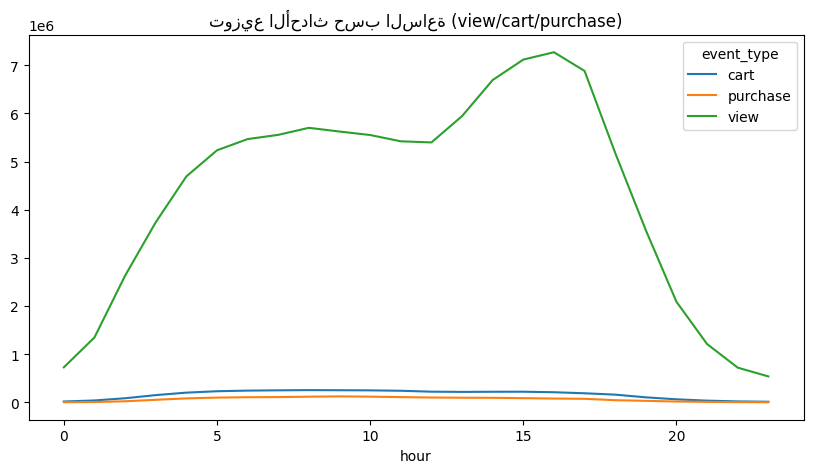

In [11]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

ddf = dd.read_parquet("/content/data/parquet_data")

ddf["event_time"] = dd.to_datetime(ddf["event_time"], errors="coerce")
ddf["hour"] = ddf["event_time"].dt.hour

with ProgressBar():
    hourly = ddf.groupby("hour")["event_type"].value_counts().compute().unstack(fill_value=0)

hourly.plot(kind="line", figsize=(10,5), title="توزيع الأحداث حسب الساعة (view/cart/purchase)")


# 2. مقارنة الأسعار بين العلامات التجارية في المشتريات فقط

In [12]:
import pandas as pd

with ProgressBar():
    purchase_df = ddf[ddf["event_type"] == "purchase"]
    brand_avg_price = purchase_df.groupby("brand")["price"].mean().compute().sort_values(ascending=False).head(10)

print("أغلى 10 علامات تجارية في المشتريات:")
print(brand_avg_price)


[########################################] | 100% Completed | 16.84 s
أغلى 10 علامات تجارية في المشتريات:
brand
kingsong         1992.330000
rado             1956.290000
dynacord         1919.480000
dreammachines    1801.820000
aerosystem       1801.820000
hartan           1801.820000
longines         1694.549474
shua             1671.935000
louiserard       1657.700000
babylock         1645.920000
Name: price, dtype: float64


# 3. نسبة التحويل (Conversion Rate)
أي: كم من مشاهدات المنتجات تتحول إلى عمليات شراء؟

In [13]:
with ProgressBar():
    views = ddf[ddf["event_type"] == "view"]["product_id"].nunique().compute()
    purchases = ddf[ddf["event_type"] == "purchase"]["product_id"].nunique().compute()

conversion_rate = (purchases / views) * 100
print(f"نسبة التحويل من مشاهدة إلى شراء: {conversion_rate:.4f}%")


[########################################] | 100% Completed | 14.69 s
[########################################] | 100% Completed | 10.59 s
نسبة التحويل من مشاهدة إلى شراء: 32.9067%


# 4. تحليل العلامات التجارية الأكثر جذبًا (بناءً على معدل الشراء من المشاهدة)

In [14]:
with ProgressBar():
    views_per_brand = ddf[ddf["event_type"] == "view"].groupby("brand")["user_id"].count().compute()
    purchases_per_brand = ddf[ddf["event_type"] == "purchase"].groupby("brand")["user_id"].count().compute()

brand_conversion = (purchases_per_brand / views_per_brand * 100).dropna().sort_values(ascending=False).head(10)
print("أكثر العلامات التجارية من حيث معدل التحويل:")
print(brand_conversion)


[########################################] | 100% Completed | 22.99 s
[########################################] | 100% Completed | 15.53 s
أكثر العلامات التجارية من حيث معدل التحويل:
brand
dotemu            50.000000
htl               20.000000
pixiebelles       20.000000
casela            14.285714
prajm-evroznak    12.500000
yokito            11.111111
yoshioki          11.111111
lamel             11.111111
doona             10.000000
maja               9.090909
Name: user_id, dtype: float64


CSV

In [15]:
import os
import dask.dataframe as dd
import pandas as pd
from dask.diagnostics import ProgressBar


DATA_PARQUET = "/content/data/parquet_data"
RESULTS_DIR = "/content/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

print("جارٍ تحميل البيانات من Parquet...")
ddf = dd.read_parquet(DATA_PARQUET)




ddf["event_time"] = dd.to_datetime(ddf["event_time"], errors="coerce")






with ProgressBar():
    event_counts = ddf["event_type"].value_counts().compute()
event_counts.to_csv(f"{RESULTS_DIR}/event_counts.csv", header=["count"])
print(" event_counts.csv تم حفظه")






with ProgressBar():
    avg_price = ddf.groupby("event_type")["price"].mean().compute()
avg_price.to_csv(f"{RESULTS_DIR}/avg_price_per_event.csv", header=["avg_price"])
print(" avg_price_per_event.csv تم حفظه")





with ProgressBar():
    top_brands = (
        ddf.groupby(["event_type", "brand"])["user_id"]
        .count()
        .compute()
        .reset_index()
        .rename(columns={"user_id": "count"})
    )
top_brands = (
    top_brands.sort_values(["event_type", "count"], ascending=[True, False])
    .groupby("event_type")
    .head(10)
)
top_brands.to_csv(f"{RESULTS_DIR}/top_brands_by_event.csv", index=False)
print("✔ top_brands_by_event.csv تم حفظه")





ddf["hour"] = ddf["event_time"].dt.hour
with ProgressBar():
    hourly = ddf.groupby("hour")["event_type"].value_counts().compute().unstack(fill_value=0)
hourly.to_csv(f"{RESULTS_DIR}/hourly_event_distribution.csv")
print("✔ hourly_event_distribution.csv تم حفظه")





with ProgressBar():
    views = ddf[ddf["event_type"] == "view"]["product_id"].nunique().compute()
    purchases = ddf[ddf["event_type"] == "purchase"]["product_id"].nunique().compute()
conversion_rate = (purchases / views) * 100
pd.DataFrame(
    {"views": [views], "purchases": [purchases], "conversion_rate(%)": [conversion_rate]}
).to_csv(f"{RESULTS_DIR}/conversion_rate.csv", index=False)
print("✔ conversion_rate.csv تم حفظه")





with ProgressBar():
    views_per_brand = ddf[ddf["event_type"] == "view"].groupby("brand")["user_id"].count().compute()
    purchases_per_brand = ddf[ddf["event_type"] == "purchase"].groupby("brand")["user_id"].count().compute()

brand_conversion = (
    (purchases_per_brand / views_per_brand * 100)
    .dropna()
    .sort_values(ascending=False)
    .reset_index()
)
brand_conversion.columns = ["brand", "conversion_rate(%)"]
brand_conversion.to_csv(f"{RESULTS_DIR}/brand_conversion_rate.csv", index=False)
print(" brand_conversion_rate.csv تم حفظه")


print("\n تم إنشاء جميع ملفات النتائج في:", RESULTS_DIR)
print("المخرجات:")
for f in os.listdir(RESULTS_DIR):
    print(" -", f)


جارٍ تحميل البيانات من Parquet...
[########################################] | 100% Completed | 8.33 s
 event_counts.csv تم حفظه
[########################################] | 100% Completed | 12.68 s
 avg_price_per_event.csv تم حفظه
[########################################] | 100% Completed | 21.05 s
✔ top_brands_by_event.csv تم حفظه
[########################################] | 100% Completed | 118.11 s
✔ hourly_event_distribution.csv تم حفظه
[########################################] | 100% Completed | 11.56 s
[########################################] | 100% Completed | 9.52 s
✔ conversion_rate.csv تم حفظه
[########################################] | 100% Completed | 21.46 s
[########################################] | 100% Completed | 14.72 s
 brand_conversion_rate.csv تم حفظه

 تم إنشاء جميع ملفات النتائج في: /content/results
المخرجات:
 - avg_price_per_event.csv
 - conversion_rate.csv
 - top_brands_by_event.csv
 - brand_conversion_rate.csv
 - hourly_event_distribution.csv
 - event_

# إنشاء المقارنة النهائية

 pandas + chunksize done in 113.74 s
[########################################] | 100% Completed | 237.16 s
 Dask done in 237.43 s
  (compressed) done in 325.80 s

 تم حفظ جدول المقارنة في: /content/results/methods_comparison.csv


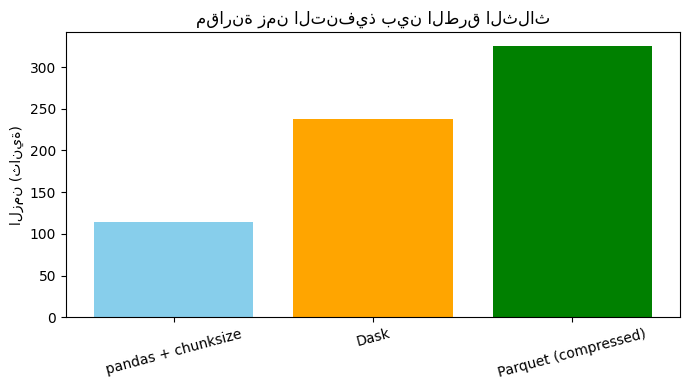

 تم حفظ الرسم البياني  في: /content/results/methods_comparison.png


,الطريقة,الزمن المستغرق (ثانية),حجم البيانات (MB),المزايا,العيوب
0,pandas + chunksize,113.740547,5668.612855,تعمل على أي جهاز - لا تسبب Out of Memory,تحتاج إلى حلقة for وتكرار يدوي
1,Dask,237.425867,23528.842545,تتعامل مع بيانات ضخمة بسهولة وسرعة عالية,تحتاج إلى مكتبة إضافية Dask
2,Parquet (compressed),325.799050,3742.870291,تحسن التخزين وتسرع القراءة المستقبلية,تستهلك وقت أولي كبير للتحويل


In [16]:
import os, time, gc, pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

DATA_DIR = "/content/data"
RESULTS_DIR = "/content/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

def dir_size(path):
    if os.path.isfile(path):
        return os.path.getsize(path)
    total = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            total += os.path.getsize(os.path.join(dirpath, f))
    return total


import pandas as pd
from collections import Counter

pandas_start = time.time()
event_counter = Counter()
chunksize = 2_000_000
file_path = os.path.join(DATA_DIR, "2019-Oct.csv")

for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
    event_counter.update(chunk["event_type"].values)
    del chunk
    gc.collect()

pandas_end = time.time()
pandas_time = pandas_end - pandas_start
pandas_size = dir_size(file_path)

print(f" pandas + chunksize done in {pandas_time:.2f} s")


dask_start = time.time()
with ProgressBar():
    ddf = dd.read_csv(os.path.join(DATA_DIR, "*.csv"), assume_missing=True, blocksize="64MB")
    _ = ddf["event_type"].value_counts().compute()
dask_end = time.time()
dask_time = dask_end - dask_start
dask_size = dir_size(DATA_DIR)
print(f" Dask done in {dask_time:.2f} s")


parquet_dir = os.path.join(DATA_DIR, "parquet_data_auto")
parquet_start = time.time()
ddf.to_parquet(parquet_dir, engine="pyarrow", compression="snappy", write_index=False)
parquet_end = time.time()
parquet_time = parquet_end - parquet_start
parquet_size = dir_size(parquet_dir)
print(f"  (compressed) done in {parquet_time:.2f} s")

comparison = pd.DataFrame({
    "الطريقة": ["pandas + chunksize", "Dask", "Parquet (compressed)"],
    "الزمن المستغرق (ثانية)": [pandas_time, dask_time, parquet_time],
    "حجم البيانات (MB)": [pandas_size/1e6, dask_size/1e6, parquet_size/1e6],
    "المزايا": [
        "تعمل على أي جهاز - لا تسبب Out of Memory",
        "تتعامل مع بيانات ضخمة بسهولة وسرعة عالية",
        "تحسن التخزين وتسرع القراءة المستقبلية"
    ],
    "العيوب": [
        "تحتاج إلى حلقة for وتكرار يدوي",
        "تحتاج إلى مكتبة إضافية Dask",
        "تستهلك وقت أولي كبير للتحويل"
    ]
})

comparison.to_csv(f"{RESULTS_DIR}/methods_comparison.csv", index=False, encoding='utf-8-sig')
print("\n تم حفظ جدول المقارنة في:", f"{RESULTS_DIR}/methods_comparison.csv")


plt.figure(figsize=(7,4))
plt.bar(comparison["الطريقة"], comparison["الزمن المستغرق (ثانية)"], color=['skyblue','orange','green'])
plt.title("مقارنة زمن التنفيذ بين الطرق الثلاث")
plt.ylabel("الزمن (ثانية)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/methods_comparison.png")
plt.show()


print(" تم حفظ الرسم البياني  في:", f"{RESULTS_DIR}/methods_comparison.png")

display(comparison)